# Setup: Imports & Data Generation

In [1]:
# Standard libraries
from objective_functions import compute_objective
from prox_operators import prox_l1, prox_elastic_net
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import iterative_solvers
import importlib

importlib.reload(iterative_solvers)

# now re-import the functions
from iterative_solvers import estimate_lipschitz, ista, fista, fista_delta

# Data generation utilities
from easy_boston_data import (
    generate_correlated_boston_like_data
)

# Core solvers
from iterative_solvers import ista, fista, fista_delta
from lbfgs import LBFGSSolver

# Global stopping tolerance for all solvers
# The value 1e-6 ensures convergence to a solution where:
#   ‖∇f(x_k)‖₂ ≤ ε   or   ‖x_{k+1} − x_k‖₂ ≤ ε
# which are both standard criteria in the slides.
# This threshold balances numerical precision and practical stopping.
TOL = 1e-10


In [2]:
# --- METRICS INFRASTRUCTURE (ADD THIS CELL) ---
import time, tracemalloc, numpy as np

# 1) Store per tutti i risultati
records = []

# 2) Buffer per i tempi di ogni prox-call
prox_call_times = []

# 3) Funzioni originali
import prox_operators
_orig_l1 = prox_operators.prox_l1
_orig_en = prox_operators.prox_elastic_net

# 4) Wrappers per misurare ciascun prox
def timed_prox_l1(v, t):
    start = time.perf_counter()
    out = _orig_l1(v, t)
    prox_call_times.append(time.perf_counter() - start)
    return out

def timed_prox_elastic_net(v, t, a1, a2):
    start = time.perf_counter()
    out = _orig_en(v, t, a1, a2)
    prox_call_times.append(time.perf_counter() - start)
    return out

# 5) Patch dei moduli
prox_operators.prox_l1          = timed_prox_l1
prox_operators.prox_elastic_net = timed_prox_elastic_net
import iterative_solvers
iterative_solvers.prox_l1          = timed_prox_l1
iterative_solvers.prox_elastic_net = timed_prox_elastic_net

# 6) Helper per le statistiche sui prox-call
def get_prox_stats():
    if prox_call_times:
        return {
            'prox_min_s':  np.min(prox_call_times),
            'prox_max_s':  np.max(prox_call_times),
            'prox_mean_s': np.mean(prox_call_times),
            'prox_var_s':  np.var(prox_call_times),
            'prox_std_s':  np.std(prox_call_times),
        }
    else:
        return dict.fromkeys(
            ['prox_min_s','prox_max_s','prox_mean_s','prox_var_s','prox_std_s'],
            0.0
        )

In [ ]:
# === REBIND SOLVERS TO PATCHED VERSIONS ===
# so that all downstream calls use our wrapped fns
from iterative_solvers import ista, fista, fista_delta
from lbfgs import LBFGSSolver

# Preprocessing & Regularization Settings

In [4]:
# 3.1.1 Generate correlated data & standardize
A, b, x_true = generate_correlated_boston_like_data(m=1000, noise_std=1.0)
A = (A - A.mean(axis=0)) / A.std(axis=0)
b = b - b.mean()

# 3.1.2 Define regularization scenarios
basic_regs = [
    # Pure Lasso variants (α₂=0)
    {'name': 'lasso', 'alpha1': 0.3, 'alpha2': 0.0},
    {'name': 'lasso', 'alpha1': 0.6, 'alpha2': 0.0},
    {'name': 'lasso', 'alpha1': 1.0, 'alpha2': 0.0},

    # Pure Ridge variants (α₁=0)
    {'name': 'ridge', 'alpha1': 0.0, 'alpha2': 0.3},
    {'name': 'ridge', 'alpha1': 0.0, 'alpha2': 0.6},
    {'name': 'ridge', 'alpha1': 0.0, 'alpha2': 1.0},

    # Elastic Net ≃ Lasso (α₂ very small < eps)
    {'name': 'elasticnet', 'alpha1': 0.3, 'alpha2': 1e-9},

    # Elastic Net ≃ Ridge (α₁ very small < eps)
    {'name': 'elasticnet', 'alpha1': 1e-6, 'alpha2': 0.5},

    # Balanced Elastic Net (both >> eps)
    {'name': 'elasticnet', 'alpha1': 0.3, 'alpha2': 0.3},
]




# Alpha selection

In [ ]:
def select_effective_alphas(reg_type, alpha1, alpha2, eps=1e-8):
    """
    Determine the actual ℓ₁ (alpha1) and ℓ₂ (alpha2) weights to use,
    treating any component < eps as zero.

    - Pure Lasso   : keep ℓ₁, zero ℓ₂
    - Pure Ridge   : zero ℓ₁, keep ℓ₂
    - Elastic-Net  :
        • if ℓ₁ negligible and ℓ₂ significant  → Ridge
        • if ℓ₂ negligible and ℓ₁ significant  → Lasso
        • if both significant                  → Elastic-Net
        • if both negligible                   → No regularization
    """
    if reg_type == "lasso":
        return alpha1, 0.0

    elif reg_type == "ridge":
        return 0.0, alpha2

    elif reg_type == "elasticnet":
        l1_small = abs(alpha1) < eps
        l2_small = abs(alpha2) < eps

        if l1_small and not l2_small:
            # ℓ₁ term is negligible ⇒ pure Ridge
            return 0.0, alpha2

        elif l2_small and not l1_small:
            # ℓ₂ term is negligible ⇒ pure Lasso
            return alpha1, 0.0

        elif l1_small and l2_small:
            # both negligible ⇒ no regularization
            return 0.0, 0.0

        else:
            # both non-negligible ⇒ true Elastic-Net
            return alpha1, alpha2

    else:
        raise ValueError(f"Unsupported reg_type={reg_type!r}")


# Baseline: ISTA vs FISTA

In [ ]:
# Number of repetitions per scenario (for meaningful variance/std)
REPS = 5

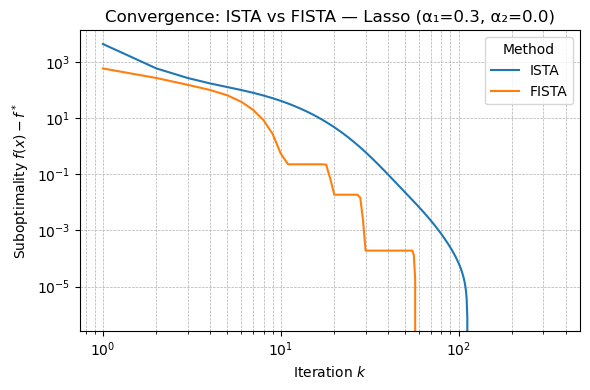

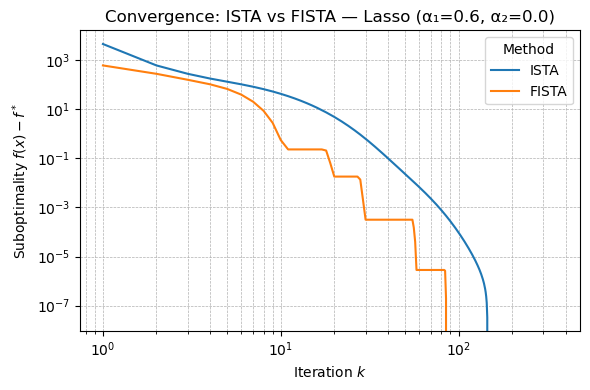

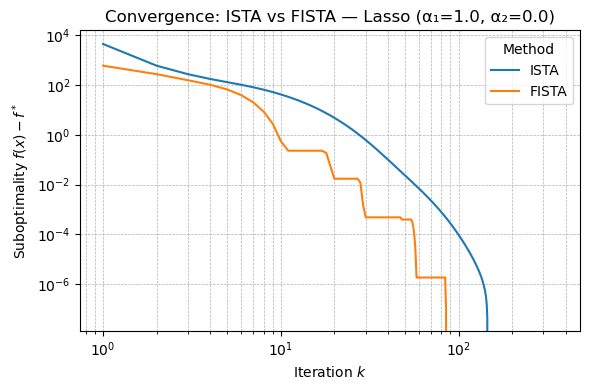

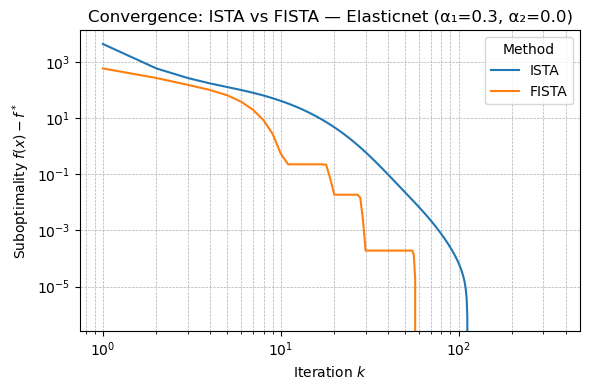

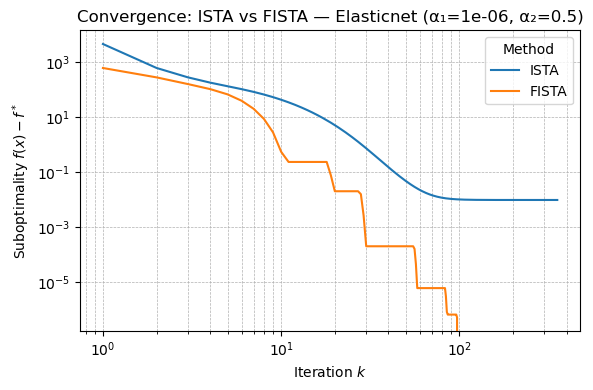

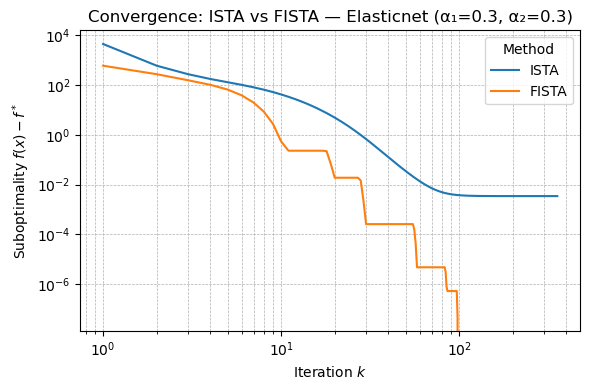

   method regularizer    alpha1  alpha2  iterations  runtime_s  mem_current_b  \
0    ISTA       lasso  0.300000     0.0         359   0.054693          22792   
1   FISTA       lasso  0.300000     0.0          78   0.022299          22792   
2    ISTA       lasso  0.300000     0.0         359   0.031457          21488   
3   FISTA       lasso  0.300000     0.0          78   0.018576          21488   
4    ISTA       lasso  0.300000     0.0         359   0.026636          21488   
5   FISTA       lasso  0.300000     0.0          78   0.019570          21488   
6    ISTA       lasso  0.300000     0.0         359   0.035424          21432   
7   FISTA       lasso  0.300000     0.0          78   0.019164          21432   
8    ISTA       lasso  0.300000     0.0         359   0.035101          21432   
9   FISTA       lasso  0.300000     0.0          78   0.025102          21432   
10   ISTA       lasso  0.600000     0.0         359   0.036016          33024   
11  FISTA       lasso  0.600

In [7]:
n, m = A.shape[1], A.shape[0]

for reg in basic_regs:
    for rep in range(REPS):
        # raw settings from scenario
        name_raw = reg['name']      # “lasso”, “ridge” or “elasticnet”
        a1_raw, a2_raw = reg['alpha1'], reg['alpha2']

        # 1) sanitize alphas: tiny values → zero
        a1, a2 = select_effective_alphas(name_raw, a1_raw, a2_raw)

        # 2) define smooth part g, its gradient, and prox operator
        if name_raw == 'lasso':
            def g(x):
                r = A @ x - b
                return 0.5 * r.dot(r)
            def grad_g(x):
                return A.T @ (A @ x - b)
            prox_h = lambda v, t: prox_l1(v, t * a1)
            L0 = estimate_lipschitz(A)
            L  = L0

        elif name_raw == 'elasticnet':
            def g(x):
                r = A @ x - b
                return 0.5 * r.dot(r) + a2 * x.dot(x)
            def grad_g(x):
                return A.T @ (A @ x - b) + 2 * a2 * x
            prox_h = lambda v, t: prox_elastic_net(v, t, a1, a2)
            L0 = estimate_lipschitz(A)
            L  = L0 + 2 * a2

        else:
            # skip pure ridge in this block
            continue

        # 3) run ISTA with history
        x0 = np.zeros(n)
        prox_call_times.clear()
        tracemalloc.start()
        t0 = time.perf_counter()
        x_i, hist_i = ista(
            x0, g, grad_g, prox_h, L,
            backtracking=False,
            t_init=None,
            max_iter=500,
            tol=TOL,
            return_history=True
        )
        t_ista = time.perf_counter() - t0
        mem_c, mem_p = tracemalloc.get_traced_memory()
        tracemalloc.stop()
        stats = get_prox_stats()

        # ensure history was returned
        if hist_i is None or 'x' not in hist_i:
            raise RuntimeError(f"ISTA did not return history for '{name_raw}'")

        # 4) build ISTA objective history
        obj_i = [
            compute_objective(xk, A, b, name_raw, a1, a2)
            for xk in hist_i['x']
        ]

        # 5) run FISTA with history
        prox_call_times.clear()
        tracemalloc.start()
        t0 = time.perf_counter()
        x_f, hist_f = fista(
            A, b, name_raw, a1, a2,
            max_iter=500,
            tol=TOL,
            return_history=True
        )
        t_fista = time.perf_counter() - t0
        mem_c, mem_p = tracemalloc.get_traced_memory()
        tracemalloc.stop()
        stats = get_prox_stats()

        if hist_f is None or 'obj' not in hist_f:
            raise RuntimeError(f"FISTA did not return history for '{name_raw}'")

        obj_f = hist_f['obj']

        # 6) plot convergence envelopes
        f_star = obj_f[-1]
        ks_i   = np.arange(1, len(obj_i) + 1)
        ks_f   = np.arange(1, len(obj_f) + 1)

        if rep == 0:
            plt.figure(figsize=(6, 4))
            plt.loglog(ks_i, np.minimum.accumulate(np.array(obj_i) - f_star), '-', label='ISTA')
            plt.loglog(ks_f, np.minimum.accumulate(np.array(obj_f) - f_star), '-', label='FISTA')
            plt.title(f"Convergence: ISTA vs FISTA — {name_raw.title()} (α₁={a1}, α₂={a2})")
            plt.xlabel('Iteration $k$')
            plt.ylabel('Suboptimality $f(x) - f^*$')
            plt.grid(True, which='both', ls='--', lw=0.5)
            plt.legend(title='Method')
            plt.tight_layout()
            plt.show()

        # 7) record summary
        records += [
            {
                'method':      'ISTA',
                'regularizer': name_raw,
                'alpha1':      a1,
                'alpha2':      a2,
                'iterations':  len(obj_i),
                'runtime_s':   t_ista,
                'mem_current_b': mem_c,
                'mem_peak_b':    mem_p,
                **stats
            },
            {
                'method':      'FISTA',
                'regularizer': name_raw,
                'alpha1':      a1,
                'alpha2':      a2,
                'iterations':  len(obj_f),
                'runtime_s':   t_fista,
                'mem_current_b': mem_c,
                'mem_peak_b':    mem_p,
                **stats
            },
        ]

# aggregate results
df_basic = pd.DataFrame(records)
print(df_basic)


# FISTA vs FISTA-Delta Comparison

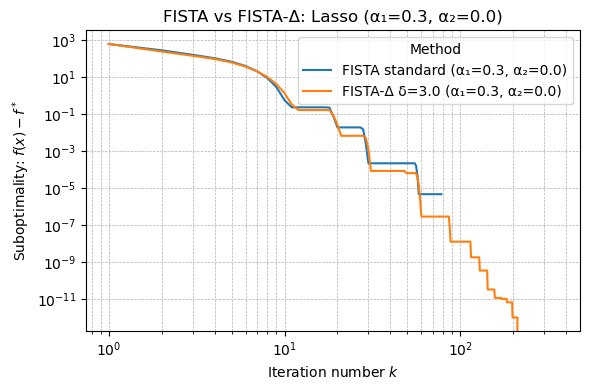

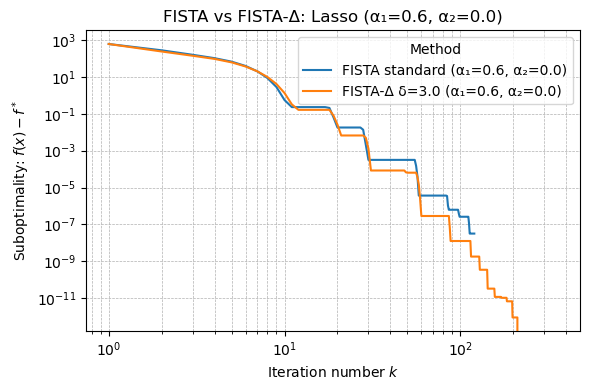

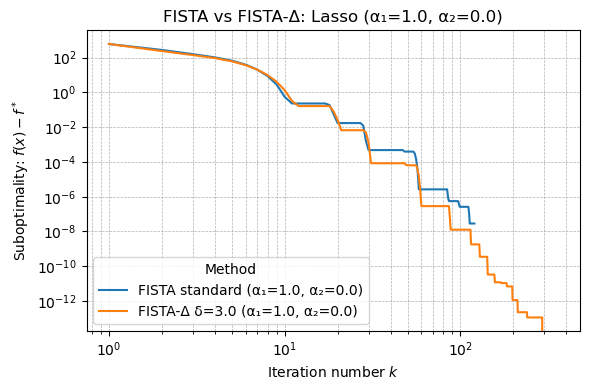

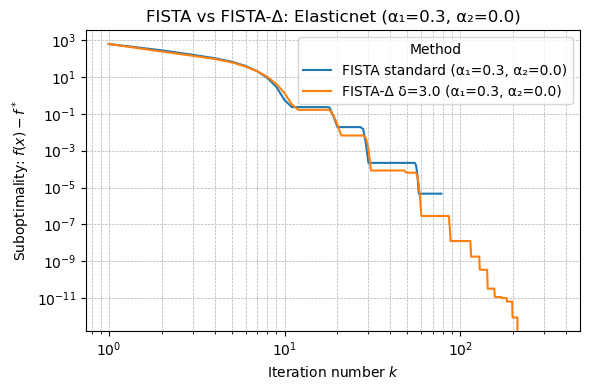

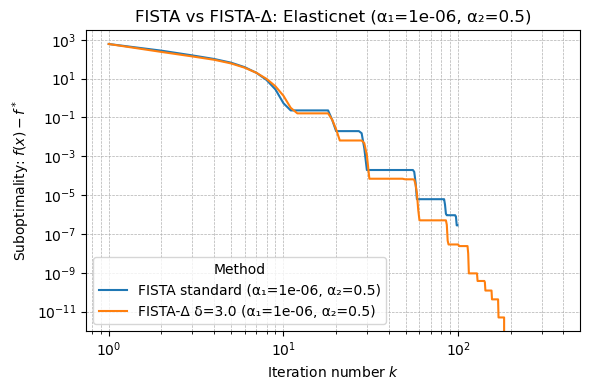

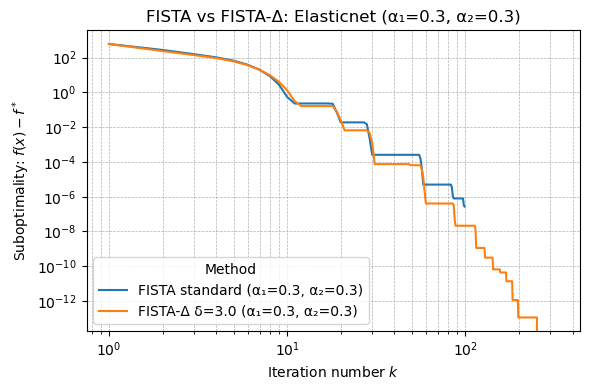

      method regularizer  alpha1  alpha2  iterations  runtime_s  \
0       ISTA       lasso     0.3     0.0         359   0.054693   
1      FISTA       lasso     0.3     0.0          78   0.022299   
2       ISTA       lasso     0.3     0.0         359   0.031457   
3      FISTA       lasso     0.3     0.0          78   0.018576   
4       ISTA       lasso     0.3     0.0         359   0.026636   
..       ...         ...     ...     ...         ...        ...   
115  FISTA-Δ  elasticnet     0.3     0.3         329   0.044782   
116    FISTA  elasticnet     0.3     0.3          99   0.028935   
117  FISTA-Δ  elasticnet     0.3     0.3         329   0.046831   
118    FISTA  elasticnet     0.3     0.3          99   0.025576   
119  FISTA-Δ  elasticnet     0.3     0.3         329   0.046629   

     mem_current_b  mem_peak_b  prox_min_s  prox_max_s  prox_mean_s  \
0            22792       47976    0.000010    0.000037     0.000014   
1            22792       47976    0.000010    0.00003

In [8]:
# ── Block 3: FISTA vs FISTA-Δ for Lasso & Elastic-Net ──────────────────
delta = 3.0

for reg in basic_regs:
    for rep in range(REPS):
        # raw settings
        name_raw, a1_raw, a2_raw = reg['name'], reg['alpha1'], reg['alpha2']

        # 0) sanitize tiny α’s → 0
        a1, a2 = select_effective_alphas(name_raw, a1_raw, a2_raw)

        # only Lasso or Elastic-Net with nonzero L1
        if name_raw not in ('lasso', 'elasticnet') or a1 <= 0.0:
            continue

        # 1) Standard FISTA (with history)
        prox_call_times.clear()
        tracemalloc.start()
        t0 = time.perf_counter()
        x_std, hist_std = fista(
            A, b, name_raw, a1, a2,
            max_iter=500,
            tol=TOL,
            return_history=True
        )
        t_std = time.perf_counter() - t0
        mem_c, mem_p = tracemalloc.get_traced_memory()
        tracemalloc.stop()
        stats = get_prox_stats()
        obj_std = hist_std['obj']

        # 2) FISTA-Δ variant
        prox_call_times.clear()
        tracemalloc.start()
        t0 = time.perf_counter()
        x_del, obj_del = fista_delta(
            A, b, name_raw, a1, a2,
            delta=delta,
            max_iter=500,
            tol=TOL
        )
        t_del = time.perf_counter() - t0
        mem_c, mem_p = tracemalloc.get_traced_memory()
        tracemalloc.stop()
        stats = get_prox_stats()

        # 3) Build suboptimality envelopes
        f_star = min(obj_std[-1], obj_del[-1])
        ks_std = np.arange(1, len(obj_std) + 1)
        ks_del = np.arange(1, len(obj_del) + 1)
        env_std = np.minimum.accumulate(np.array(obj_std) - f_star)
        env_del = np.minimum.accumulate(np.array(obj_del) - f_star)

        # 4) Plot
        if rep == 0:
            plt.figure(figsize=(6, 4))
            plt.loglog(ks_std, env_std, '-', label=f"FISTA standard (α₁={a1}, α₂={a2})")
            plt.loglog(ks_del, env_del, '-', label=f"FISTA-Δ δ={delta} (α₁={a1}, α₂={a2})")
            plt.title(f"FISTA vs FISTA-Δ: {name_raw.title()} (α₁={a1}, α₂={a2})")
            plt.xlabel('Iteration number $k$')
            plt.ylabel('Suboptimality: $f(x) - f^*$')
            plt.grid(True, which='both', ls='--', lw=0.5)
            plt.legend(title='Method')
            plt.tight_layout()
            plt.show()

        # 5) Record results
        records += [
            {
                'method':      'FISTA',
                'regularizer': name_raw,
                'alpha1':      a1,
                'alpha2':      a2,
                'iterations':  len(hist_std['obj']),
                'runtime_s':   t_std,
                'mem_current_b': mem_c,
                'mem_peak_b':    mem_p,
                **stats
            },
            {
                'method':      'FISTA-Δ',
                'regularizer': name_raw,
                'alpha1':      a1,
                'alpha2':      a2,
                'iterations':  len(obj_del),
                'runtime_s':   t_del,
                'mem_current_b': mem_c,
                'mem_peak_b':    mem_p,
                **stats
            },
        ]

# 6) Aggregate into DataFrame
df_variants = pd.DataFrame(records)
print(df_variants)


# Ridge Regression via L-BFGS

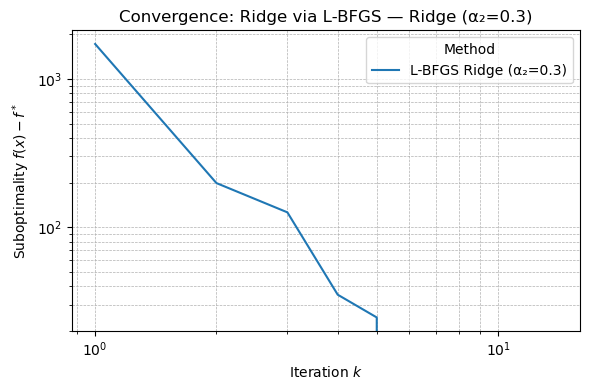

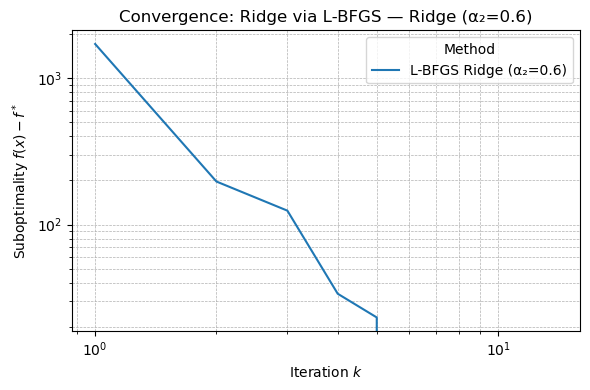

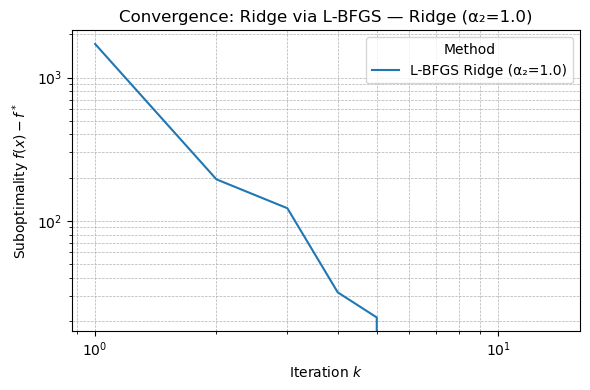

     method regularizer  alpha1  alpha2  iterations  runtime_s  mem_current_b  \
0      ISTA       lasso     0.3     0.0         359   0.054693          22792   
1     FISTA       lasso     0.3     0.0          78   0.022299          22792   
2      ISTA       lasso     0.3     0.0         359   0.031457          21488   
3     FISTA       lasso     0.3     0.0          78   0.018576          21488   
4      ISTA       lasso     0.3     0.0         359   0.026636          21488   
..      ...         ...     ...     ...         ...        ...            ...   
130  L-BFGS       ridge     0.0     1.0          14   0.003126           3800   
131  L-BFGS       ridge     0.0     1.0          14   0.004343         151390   
132  L-BFGS       ridge     0.0     1.0          14   0.002887           3744   
133  L-BFGS       ridge     0.0     1.0          14   0.002819           3736   
134  L-BFGS       ridge     0.0     1.0          14   0.002940           3760   

     mem_peak_b  prox_min_s

In [9]:
# ── Block 2: Ridge & “≈ Ridge” via L-BFGS ────────────────────────────────
eps = 1e-8

for reg in basic_regs:
    for rep in range(REPS):
        # raw settings
        name_raw, a1_raw, a2_raw = reg['name'], reg['alpha1'], reg['alpha2']
        # sanitize α’s
        a1, a2 = select_effective_alphas(name_raw, a1_raw, a2_raw, eps=eps)

        # pick only true Ridge or Elastic-Net ≃ Ridge
        is_ridge_case = (name_raw == 'ridge') or (name_raw == 'elasticnet' and a1_raw < eps)
        if not is_ridge_case:
            continue

        # dynamic label
        if name_raw == 'ridge':
            label = f"Ridge (α₂={a2})"
        else:
            label = f"Elastic-Net ≃ Ridge (α₁≈0, α₂={a2})"

        # configure L-BFGS with the effective alphas
        solver = LBFGSSolver(
            reg_type='ridge',
            alpha1=0.0,   # pure ℓ₂
            alpha2=a2,
            max_iter=500,
            tol=TOL
        )

        # run & time
        prox_call_times.clear()
        tracemalloc.start()
        t0 = time.perf_counter()
        solver.fit(A, b)
        runtime = time.perf_counter() - t0
        mem_c, mem_p = tracemalloc.get_traced_memory()
        tracemalloc.stop()
        stats = get_prox_stats()

        # plot convergence envelope
        ks = np.arange(1, len(solver.history_) + 1)
        if rep == 0:
            plt.figure(figsize=(6, 4))
            plt.loglog(
                ks,
                np.minimum.accumulate(np.array(solver.history_) - solver.final_obj_),
                '-', label=f"L-BFGS {label}"
            )
            plt.title(f"Convergence: Ridge via L-BFGS — {label}")
            plt.xlabel('Iteration $k$')
            plt.ylabel('Suboptimality $f(x)-f^*$')
            plt.grid(True, which='both', ls='--', lw=0.5)
            plt.legend(title='Method')
            plt.tight_layout()
            plt.show()

        # record summary
        records.append({
            'method':      'L-BFGS',
            'regularizer': name_raw,
            'alpha1':      0.0,
            'alpha2':      a2,
            'iterations':  len(solver.history_),
            'runtime_s':   runtime,
                'mem_current_b': mem_c,
            'mem_peak_b':    mem_p,
            **stats
        })

# assemble into DataFrame
df_ridge = pd.DataFrame(records)
print(df_ridge)


# Final metrics

In [10]:
# --- FINAL METRICS SUMMARY TABLE (REPLACE THIS CELL) ---
import pandas as pd

# build full DataFrame
df_metrics = pd.DataFrame(records)

# choose the numeric columns you want to summarize
metrics = [
    'iterations',
    'runtime_s',
    'prox_min_s','prox_max_s','prox_mean_s','prox_var_s','prox_std_s',
    'mem_current_b','mem_peak_b'
]

# group & aggregate
summary = (
    df_metrics
      .groupby(['method','regularizer','alpha1','alpha2'])[metrics]
      .agg(['min','max','mean','var','std'])
      .reset_index()
)

# for cleaner column names flatten the MultiIndex
summary.columns = [
    '_'.join(filter(None, col)).strip('_')
    for col in summary.columns.to_flat_index()
]

pd.set_option('display.float_format','{:.6f}'.format)
print(summary)

     method regularizer   alpha1   alpha2  iterations_min  iterations_max  \
0     FISTA  elasticnet 0.000001 0.500000              99              99   
1     FISTA  elasticnet 0.300000 0.000000              78              78   
2     FISTA  elasticnet 0.300000 0.300000              99              99   
3     FISTA       lasso 0.300000 0.000000              78              78   
4     FISTA       lasso 0.600000 0.000000             120             120   
5     FISTA       lasso 1.000000 0.000000             120             120   
6   FISTA-Δ  elasticnet 0.000001 0.500000             370             370   
7   FISTA-Δ  elasticnet 0.300000 0.000000             357             357   
8   FISTA-Δ  elasticnet 0.300000 0.300000             329             329   
9   FISTA-Δ       lasso 0.300000 0.000000             357             357   
10  FISTA-Δ       lasso 0.600000 0.000000             357             357   
11  FISTA-Δ       lasso 1.000000 0.000000             357             357   